In [82]:
! pip install pmdarima prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 23.1 MB/s 
     |████████████████████████████████| 9.9 MB 55.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [83]:
import numpy as np
import pandas as pd
import os
import gc
import warnings
import random
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import torch
from torch import nn
from torch.autograd import Variable

import statsmodels.api as sm
import scipy.io as sio
import pmdarima as pm
from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


In [ ]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [ ]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(26)

# **Dataset Part**

In [ ]:
 def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out


fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
data=getfile(fname)
data.head()

local file not found; accessing Google Drive


,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate
0,State,California,01/01/1976,1976,January,N,Final,9672362,8668016,1004346,0.10
1,State,California,01/01/1976,1976,January,Y,Final,9774280,8875685,898595,0.09
2,County,Los Angeles County,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.10
3,County,Los Angeles County,01/01/1976,1976,January,Y,Final,3381856,3081806,300050,0.09
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.10


In [ ]:
data['Date']= pd.to_datetime(data['Date'])
data['ts'] = data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
data['Employment Rate']=data['Employment ']/data['Labor Force']

## **Working dataset**

In [ ]:
data.to_pickle("./unemployment_working_data.pkl")  

In [ ]:
pd.read_pickle("./unemployment_working_data.pkl") 

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.09,189302400000000000,0.91
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.09,189302400000000000,0.91
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191122,MSA,"Yuba City, CA MSA",2022-04-01,2022,April,Y,Final,76952,72469,4483,0.06,1648771200000000000,0.94
191123,MSA,"Yuba City, CA MSA",2022-05-01,2022,May,Y,Final,76982,72704,4278,0.06,1651363200000000000,0.94
191124,MSA,"Yuba City, CA MSA",2022-06-01,2022,June,Y,Final,76953,72757,4196,0.06,1654041600000000000,0.95
191125,MSA,"Yuba City, CA MSA",2022-07-01,2022,July,Y,Final,76873,72681,4192,0.06,1656633600000000000,0.95


## **Debug dataset**

In [ ]:
df_debug = data.sample(n=2000)

In [ ]:
df_debug.to_pickle("./unemployment_debug_data.pkl") 

# **Visulization and Descriptive Statistics Part**

## **Data Change Over Time**

1. Our group aim to use data to predict California's employment rate over the next decade. So the first step, we want to see the Employment and unemployment change in California over 45 years. 



From the plot, we could see that the unemployment number remained almost constant, but the employment number kept rising. 

Both the Unemployment rate and employment rate rise and fall cyclically and become more severe.

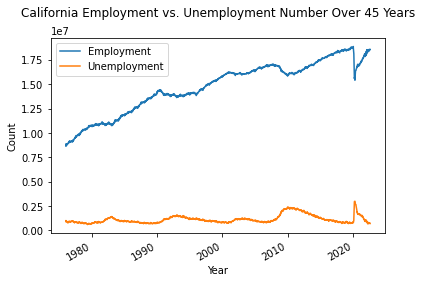

In [ ]:
#data['Employment Rate']=data['Employment']/data['Labor Force']
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
subData_County = data.loc[(data['Area Type']=='County')]
subData_State = data.loc[(data['Area Type']=='State')]

Pre = subData_State[['Date', 'Employment','Unemployment']]
Pre.set_index(["Date"], inplace=True)
Pre.plot(title="California Employment vs. Unemployment Number Over 45 Years\n", ylabel="Count", xlabel="Year")

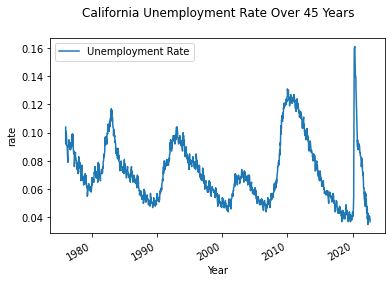

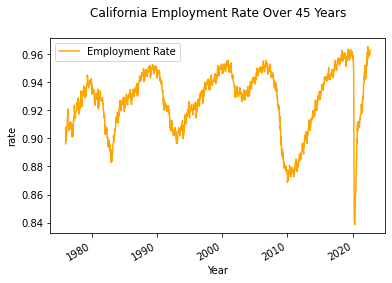

In [ ]:
Pre1 = subData_State[['Date','Unemployment Rate']]
Pre1.set_index(["Date"], inplace=True)
Pre1.plot(title="California Unemployment Rate Over 45 Years\n", ylabel="rate", xlabel="Year")
Pre2 = subData_State[['Date','Employment Rate']]
Pre2.set_index(["Date"], inplace=True)
Pre2.plot(title="California Employment Rate Over 45 Years\n", ylabel="rate", xlabel="Year", color = 'orange')

## **Geographic Factor**

2. The average unemplyment rates and emplyment rates of California Counties in the last 45 years.

[Text(0, 0.5, 'County'), Text(0.5, 0, 'Employment Rate')]

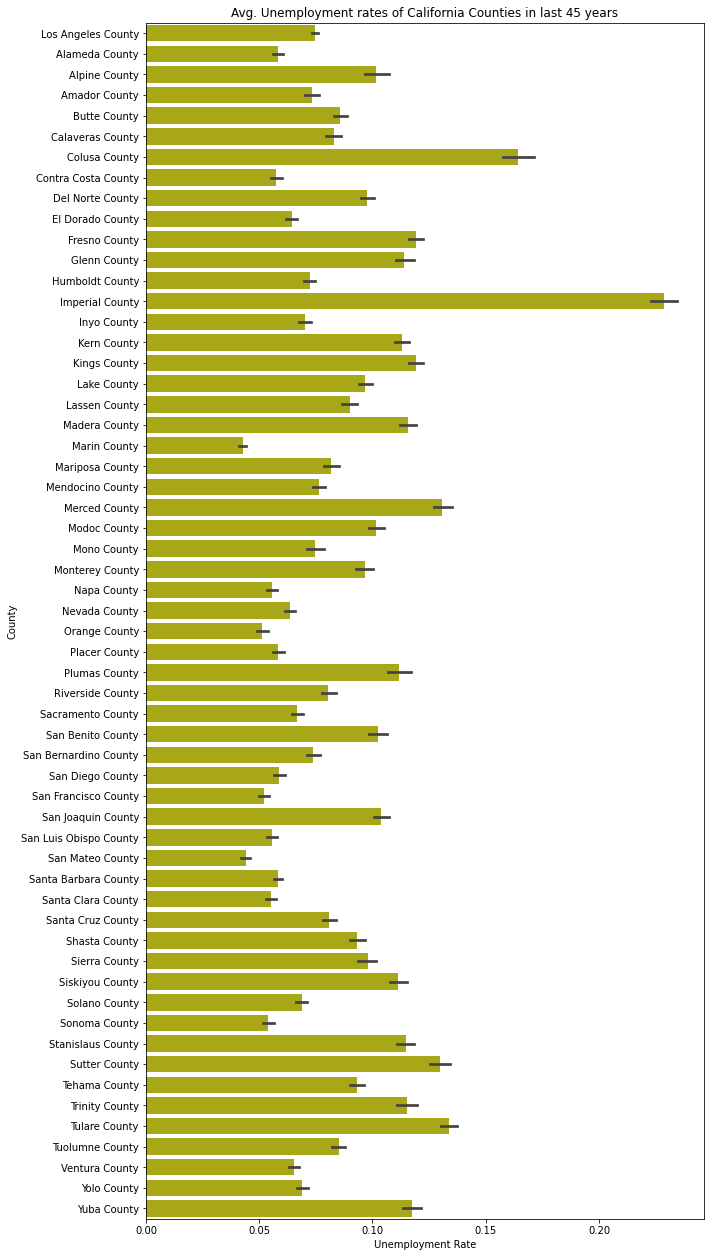

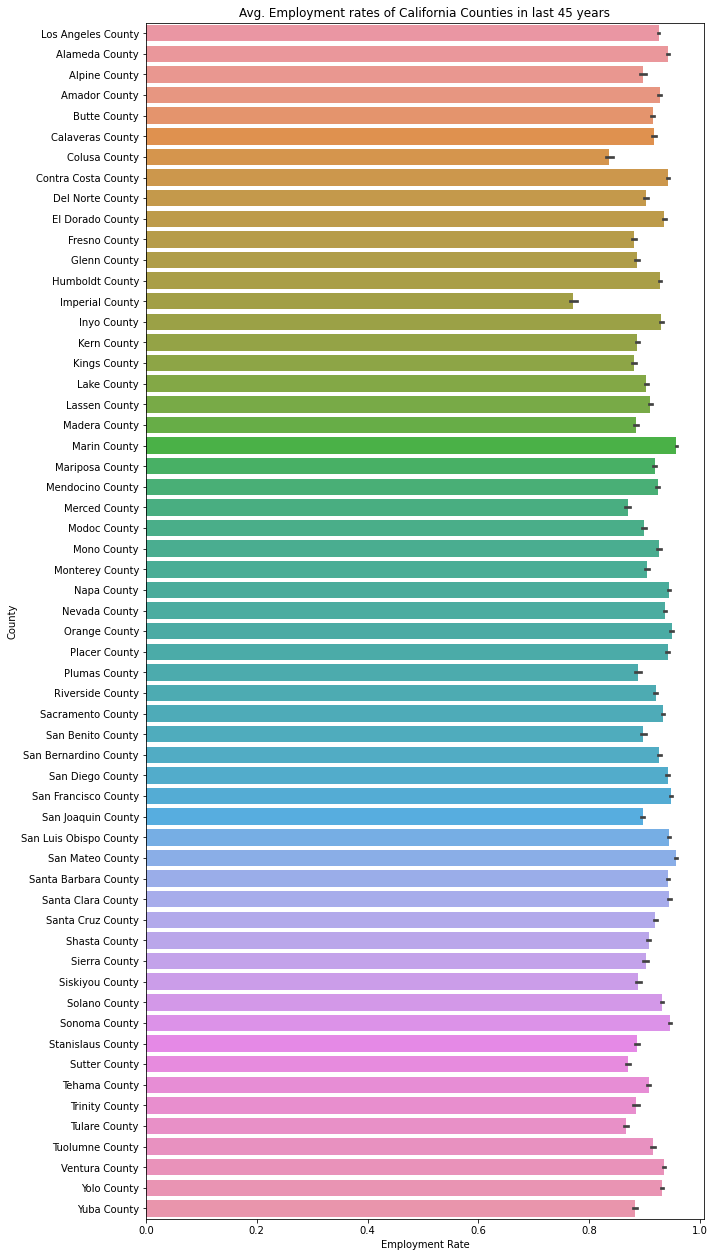

In [ ]:
ax=plt.figure(figsize=(10,22))
ax = sns.barplot(subData_County["Unemployment Rate"],                 
                 y=subData_County["Area Name"],color="y")
ax.set_title('Avg. Unemployment rates of California Counties in last 45 years')
ax.set(xlabel='Unemployment Rate', ylabel='County')

ax2=plt.figure(figsize=(10,22))
ax2 = sns.barplot(subData_County["Employment Rate"],                 
                 y=subData_County["Area Name"])
ax2.set_title('Avg. Employment rates of California Counties in last 45 years')
ax2.set(xlabel='Employment Rate', ylabel='County')

## **Data in Different Categories**

 3. show average unemployment and statistics in different categories.

In [ ]:
def plt_show(X_name, Y_name, dic, Z_name):
  
  XY = data[[X_name,Y_name]]
  X = dic.values()
  Y = []
  num = []
  for i in range(len(X)):
    Y_cat = XY[XY[X_name] == dic[i]][Y_name]
    Y.append(Y_cat.mean())
    num.append(len(Y_cat))
   #print(str(len(Y_cat)) + ' cases with '+ X_name + ' taking value ' + dic[i])

  
  plt.figure(figsize=(10,5))
  plt.pie(num, labels = X, autopct='%1.1f%%')
  title1 = 'Cases in different ' + X_name
  plt.title(title1)
  plt.show()

  plt.figure(figsize=(10,5))
  title2 = 'Average ' + Y_name + ' in different ' + X_name
  plt.bar(X,Y)
  plt.axhline(XY[Y_name].mean(), label = 'Mean of '+ Y_name, ls = ':')
  plt.legend(loc = 'best')
  plt.xlabel(X_name)
  plt.xticks(rotation=15)  
  plt.ylabel('Average ' + Y_name)
  plt.title(title2)
  plt.show()

  XZ = data[[X_name,Z_name]]
  X = dic.values()
  Z = []
  num = []
  for i in range(len(X)):
    Z_cat = XZ[XZ[X_name] == dic[i]][Z_name]
    Z.append(Z_cat.mean())
    num.append(len(Z_cat))

  plt.figure(figsize=(10,5))
  title3 = 'Average ' + Z_name + ' in different ' + X_name
  plt.bar(X,Z,color='orange')
  plt.axhline(XZ[Z_name].mean(), label = 'Mean of '+ Z_name, ls = ':')
  plt.legend(loc = 'best')
  plt.xlabel(X_name)
  plt.xticks(rotation=15)  
  plt.ylabel('Average ' + Z_name)
  plt.title(title3)
  plt.show()

**Area Type**

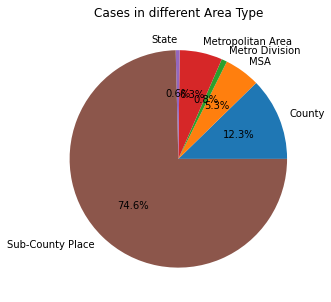

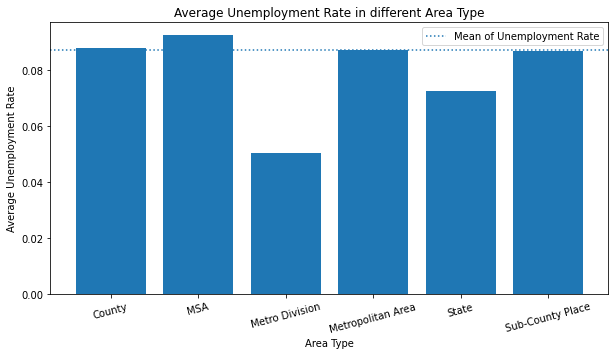

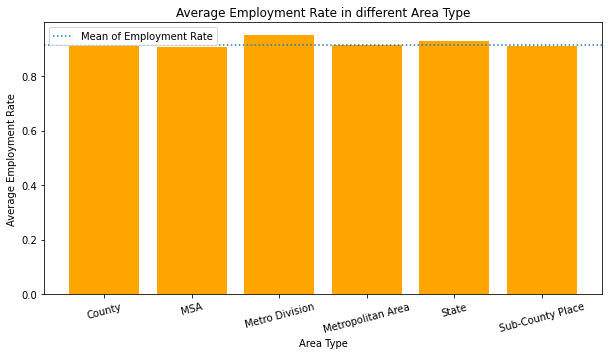

In [ ]:
X_name = 'Area Type'
Y_name = 'Unemployment Rate'
Z_name = 'Employment Rate'
dic = {0:'County', 1:'MSA', 2:'Metro Division', 3:'Metropolitan Area', 4:'State', 5:'Sub-County Place'}
plt_show(X_name, Y_name, dic, Z_name)

**Month**

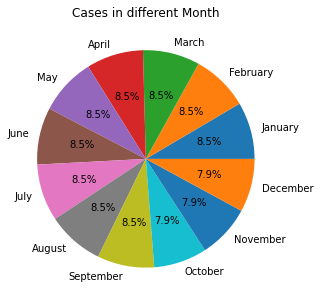

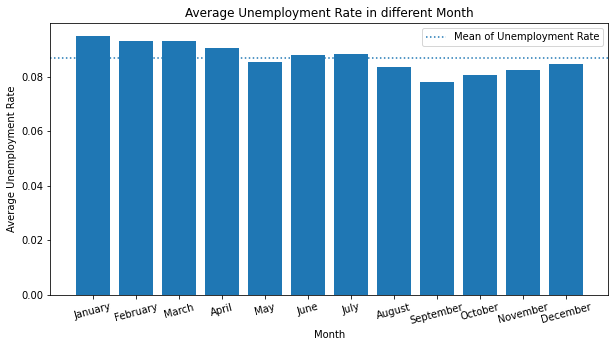

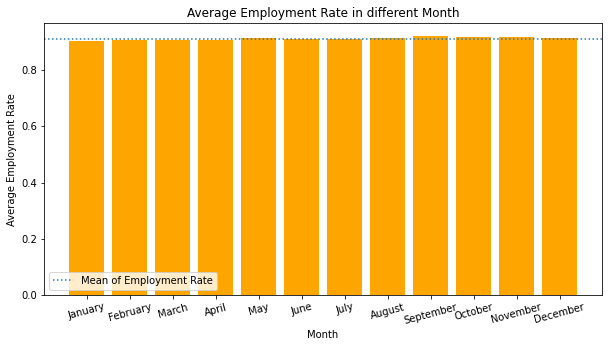

In [ ]:
X_name = 'Month'
Y_name = 'Unemployment Rate'
Z_name = 'Employment Rate'
dic = {0:'January', 1:'February', 2:'March', 3:'April', 4:'May', 5:'June', 6:'July', 7:'August', 
       8:'September', 9:'October', 10:'November', 11:'December'}
plt_show(X_name, Y_name, dic, Z_name)

**Seasonally Adjusted (Y/N)**

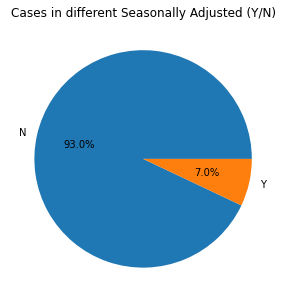

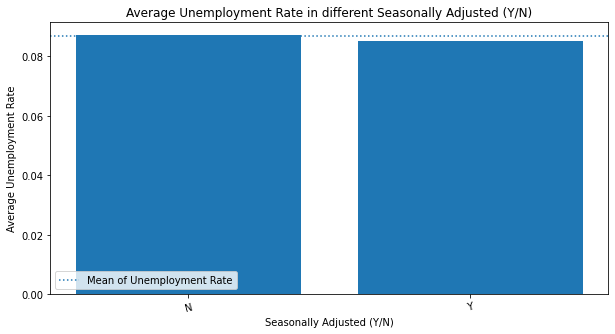

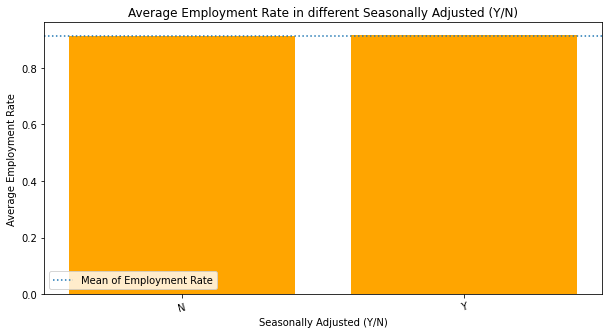

In [ ]:
X_name = 'Seasonally Adjusted (Y/N)'
Y_name = 'Unemployment Rate'
Z_name = 'Employment Rate'
dic = {0:'N', 1:'Y'}
plt_show(X_name, Y_name, dic, Z_name)

**Status (Preliminary / Final)**

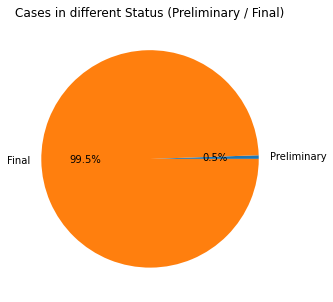

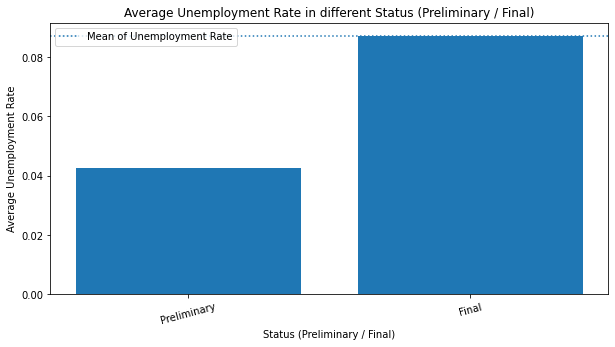

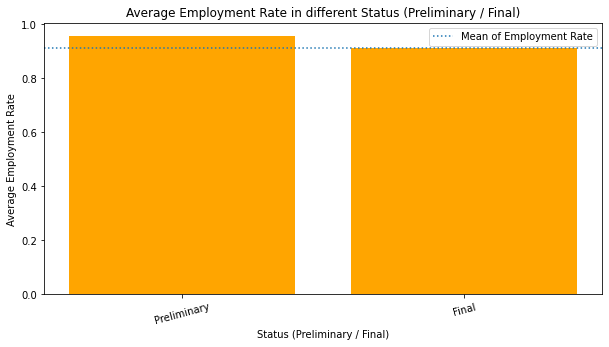

In [ ]:
X_name = 'Status (Preliminary / Final)'
Y_name = 'Unemployment Rate'
Z_name = 'Employment Rate'
dic = {0:'Preliminary', 1:'Final'}
plt_show(X_name, Y_name, dic, Z_name)



From the plots above, compared to the unemployment rate, the employment rate nearly changes in categories such as Month and Seasonally adjusted and changes slightly in categories such as area type and status (Preliminary / Final). 

The reason is that the change in the employment rate is small relative to the employment rate itself so we are going to **predict unemployment rate** instead of employment. Their relation is: employment rate + unemployment rate = 1.

# Linear regression benchmark


In [ ]:
df = pd.read_pickle("./unemployment_working_data.pkl") 
df.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.09,189302400000000000,0.91
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.09,189302400000000000,0.91
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90


In [ ]:
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
cat_col = ['Area Type', 'Area Name','Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)']
time_col = ['Date', 'Year', 'Month']
num_col = ['Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate', 'ts', 'Employment Rate']

In [ ]:
data["Area Type"].value_counts()

Sub-County Place     142596
County                23523
Metropolitan Area     12126
MSA                   10192
Metro Division         1568
State                  1122
Name: Area Type, dtype: int64

In [ ]:
data["Area Name"].value_counts()

California                            1122
Los Angeles-Long Beach-Glendale MD    1122
Los Angeles County                    1122
Tuolumne County                        393
Hanford-Corcoran MSA                   393
                                      ... 
Hawaiian Gardens city                  153
Hawthorne city                         153
Hayfork CDP                            153
Hayward city                           153
Lakewood city                          153
Name: Area Name, Length: 1050, dtype: int64

In [ ]:
data["Seasonally Adjusted (Y/N)"].value_counts()

N    177684
Y     13443
Name: Seasonally Adjusted (Y/N), dtype: int64

In [ ]:
data["Status (Preliminary / Final)"].value_counts()

Final          190074
Preliminary      1023
Prelim             30
Name: Status (Preliminary / Final), dtype: int64

Because the number of data points with 'Seasonally Adjusted (Y)' and 'Status (Preliminary)' is small coparing with the other category, 

we decide to give up these data points and ignore these two features.

In [ ]:
subData = data.loc[(data['Area Type']=='State')]
subData = subData.loc[(subData['Seasonally Adjusted (Y/N)']=='N')]
subData = subData.loc[(subData['Status (Preliminary / Final)']=='Final')]

In [ ]:
subData

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
6,State,California,1977-01-01,1977,January,N,Final,10071966,9074522,997444,0.10,220924800000000000,0.90
12,State,California,1978-01-01,1978,January,N,Final,10613102,9737384,875718,0.08,252460800000000000,0.92
18,State,California,1979-01-01,1979,January,N,Final,11098776,10309724,789052,0.07,283996800000000000,0.93
24,State,California,1980-01-01,1980,January,N,Final,11440457,10659639,780818,0.07,315532800000000000,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174252,State,California,2017-12-01,2017,December,N,Final,19113100,18290000,823100,0.04,1512086400000000000,0.96
175275,State,California,2018-12-01,2018,December,N,Final,19311900,18499900,812000,0.04,1543622400000000000,0.96
176298,State,California,2019-12-01,2019,December,N,Final,19493000,18742400,750600,0.04,1575158400000000000,0.96
177321,State,California,2020-12-01,2020,December,N,Final,18613700,16929300,1684400,0.09,1606780800000000000,0.91


In [ ]:
Pre = subData[['Date', 'Unemployment Rate']]
Pre.set_index(["Date"], inplace=True)
Pre


,Unemployment Rate
Date,
1976-01-01,0.10
1977-01-01,0.10
1978-01-01,0.08
1979-01-01,0.07
1980-01-01,0.07
...,...
2017-12-01,0.04
2018-12-01,0.04
2019-12-01,0.04


In [ ]:
dataset = Pre.values

<Figure size 864x576 with 0 Axes>

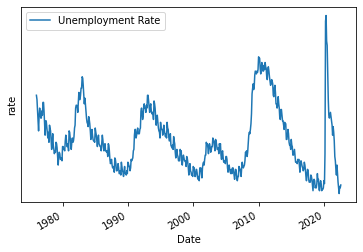

In [ ]:
plt.figure(figsize=(12, 8))
Pre.plot()
plt.ylabel('rate')
plt.yticks(np.arange(0, 1, 1))
plt.show()

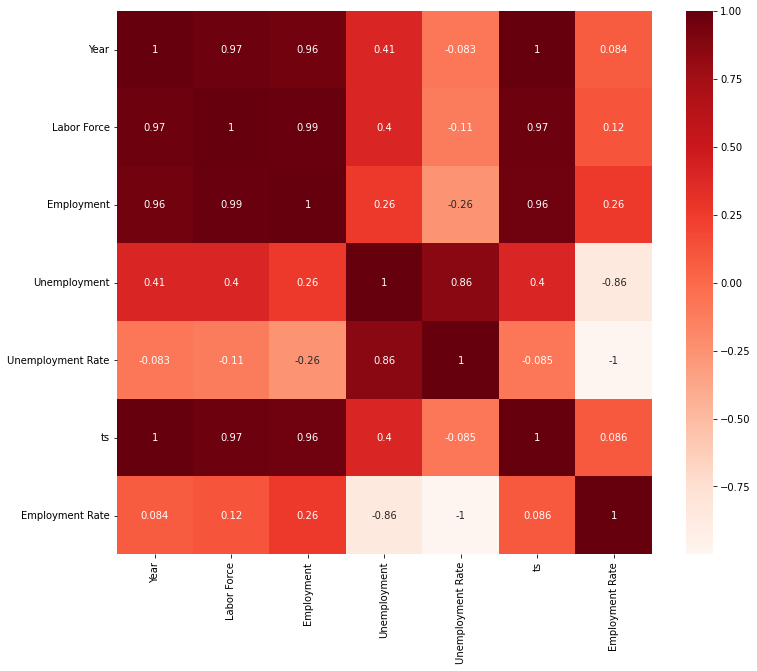

In [ ]:
plt.figure(figsize=(12,10))
cor = subData.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# -----------------------------------------
# Linear Regression Benchmark:

import datetime as dt

X = subData.drop(['Area Type','Area Name','Date','Seasonally Adjusted (Y/N)','Status (Preliminary / Final)','Employment','Unemployment', 'Unemployment Rate', 'ts', 'Employment Rate'],axis=1)
y = subData['Unemployment Rate']

# One-hot-encode Month 
X_month = pd.get_dummies(X['Month'])

# noemalize
X['Year'] = (X['Year'] - X['Year'].mean())/X['Year'].std()
X['Labor Force'] = (X['Labor Force'] - X['Labor Force'].mean())/X['Labor Force'].std()

# X_number   = X.select_dtypes(include='number')
# X_category = X.select_dtypes(exclude='number')

# One-hot-encode categorical values
# X_category = pd.get_dummies(X_category)
# X_number = (X_number - X_number.mean())/X_number.std()

X = pd.concat([X['Year'], X['Labor Force'],X_month],axis=1)
X.head()

,Year,Labor Force,April,August,December,February,January,July,June,March,May,November,October,September
0,-1.69,-2.25,0,0,0,0,1,0,0,0,0,0,0,0
6,-1.62,-2.10,0,0,0,0,1,0,0,0,0,0,0,0
12,-1.55,-1.91,0,0,0,0,1,0,0,0,0,0,0,0
18,-1.47,-1.73,0,0,0,0,1,0,0,0,0,0,0,0
24,-1.40,-1.61,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,  shuffle = False)

# Perform Linear Regression
lr = LinearRegression()
lr.fit(x_train,y_train)
R2 = lr.score(x_train,y_train)

# Linear Regression score
print('R-squared =',R2.round(2))

# Accuracy
y_prediction =  lr.predict(x_test)
print('RMSE of test is =',np.sqrt(mean_squared_error(y_test,y_prediction)))

R-squared = 0.05
RMSE of test is = 0.02198715943320409


In [ ]:
# best feature parameters
coef = lr.coef_
coef = pd.Series(coef,index=X.columns)
coef.sort_values(ascending=False).round(2)

Year           0.01
July           0.00
January        0.00
February       0.00
March          0.00
June           0.00
August         0.00
December       0.00
November       0.00
April         -0.00
September     -0.00
May           -0.00
October       -0.00
Labor Force   -0.02
dtype: float64

# **Model Parts**

## Setting

In [ ]:
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
    print('Training on GPU.')
else:
    device = torch.device("cpu")
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


## Tuning Paramaters

We adjust the hyperparameters here.

In [ ]:
INPUT_FEATURES_NUM = 5
OUTPUT_FEATURES_NUM = 1
LEARNING_RATE = 0.01
PREV_LOSS = 1000
MAX_EPOCHS = 2000

## Dataset


Considering the computing power limitation, we train the data in regions instead of training the whole model first and then branching it in regions.

In [ ]:
data['Date']= pd.to_datetime(data['Date'])
data['ts'] = data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
data['Employment Rate']=data['Employment']/data['Labor Force']
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
cat_col = ['Area Type', 'Area Name','Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)']
time_col = ['Date', 'Year', 'Month']
num_col = ['Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate', 'ts', 'Employment Rate']

In [ ]:
data["Area Name"].value_counts()

California                            1122
Los Angeles-Long Beach-Glendale MD    1122
Los Angeles County                    1122
Tuolumne County                        393
Hanford-Corcoran MSA                   393
                                      ... 
Hawaiian Gardens city                  153
Hawthorne city                         153
Hayfork CDP                            153
Hayward city                           153
Lakewood city                          153
Name: Area Name, Length: 1050, dtype: int64

## Data Processing

The data is processed according to INPUT_FEATURES_NUM in the hyperparameters, and INPUT_FEATURES_NUM is taken as INPUT_FEATURES_NUM lag observation.

In [78]:
def Area_chosen(place = 'California', index = True):
    df = data.loc[(data['Area Name'] == place)]
    df = df.loc[(df['Seasonally Adjusted (Y/N)']=='N')]
    df = df.loc[(df['Status (Preliminary / Final)']=='Final')]
    df = df[['Date', 'Unemployment Rate']]
    if index == True:
        df.set_index(["Date"], inplace=True)
    df = df.sort_index(ascending=True)
    order = []
    for i in range(INPUT_FEATURES_NUM + 1):
        j = 'R-' + str(i)
        df[j] = df['Unemployment Rate'].shift(i)
        order.append(j)
    order.reverse()
    df = df.dropna()
    df = df[order]
    return df

chose your city in california or see the data of all state

In [79]:
city = 'California'
df = Area_chosen(city)
df

,R-5,R-4,R-3,R-2,R-1,R-0
Date,,,,,,
1976-06-01,0.10,0.10,0.09,0.09,0.08,0.09
1976-07-01,0.10,0.09,0.09,0.08,0.09,0.10
1976-08-01,0.09,0.09,0.08,0.09,0.10,0.09
1976-09-01,0.09,0.08,0.09,0.10,0.09,0.09
1976-10-01,0.08,0.09,0.10,0.09,0.09,0.09
...,...,...,...,...,...,...
2022-04-01,0.05,0.05,0.06,0.05,0.04,0.04
2022-05-01,0.05,0.06,0.05,0.04,0.04,0.04
2022-06-01,0.06,0.05,0.04,0.04,0.04,0.04


Standardization and mini-bench processing

In [84]:
S = StandardScaler()
Ss = S.fit_transform(df)
Ss = Ss.astype('float32')

y = Ss[:,-1]
X = np.delete(Ss,-1,axis=1)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle = False)

train_x_tensor = train_x.reshape(-1, 1, INPUT_FEATURES_NUM)  # set batch size to 1
train_y_tensor = train_y.reshape(-1, 1, OUTPUT_FEATURES_NUM)  # set batch size to 1
 
train_x_tensor = torch.from_numpy(train_x_tensor).to(device)
train_y_tensor = torch.from_numpy(train_y_tensor).to(device)

## Linear Regression Model

In [ ]:
lr = LinearRegression()
lr.fit(train_x,train_y)

y_prediction =  lr.predict(test_x)
print('RMSE of test is =',np.sqrt(mean_squared_error(test_y,y_prediction)))

RMSE of test is = 0.4808245


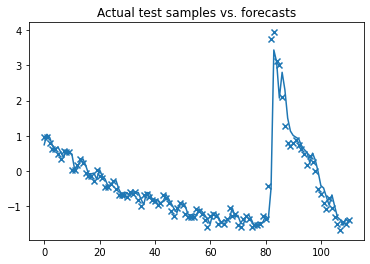

In [ ]:
plt.scatter(range(len(test_y)),test_y, marker='x')
plt.plot(range(len(y_prediction)), y_prediction)
plt.title('Actual test samples vs. forecasts')
plt.show()

## Arima Model

In [ ]:
arima = pm.auto_arima(train_y, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-696.499, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-196.033, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-635.514, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-397.755, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-198.032, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-400.210, Time=0.67 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-642.711, Time=0.75 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-692.871, Time=1.21 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-650.653, Time=1.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-195.106, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-471.845, Time=0.69 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-679.041, Time=1.02 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-689.699, Time=1.11 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-669.373, Time=0.46 sec
 ARIMA(2,1,1)(1,0,1

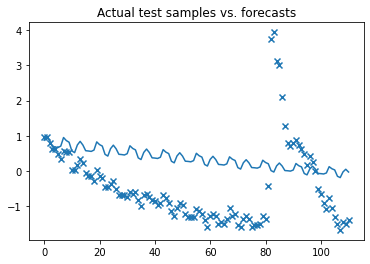

RMSE Loss of Arima is 63.48748467518842


In [ ]:
x_arima = np.arange(test_y.shape[0])
y_arima = arima.predict(n_periods=test_y.shape[0])
loss_arima = mean_squared_error(x_arima, y_arima)
plt.scatter(x_arima, test_y, marker='x')
plt.plot(x_arima, y_arima)
plt.title('Actual test samples vs. forecasts')
plt.show()
print(f"RMSE Loss of Arima is {np.sqrt(loss_arima)}")

## Prophet Model

In [85]:
ph_date = df.reset_index()['Date']
ph_train = pd.DataFrame({'ds':ph_date.iloc[0:len(train_y)], 'y':train_y})
ph_test = pd.DataFrame({'ds':ph_date.iloc[len(train_y):], 'y':test_y})


In [86]:
ph_model = Prophet()
ph_model.fit(ph_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r36c2_a/n1508x3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r36c2_a/hpraq1am.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26344', 'data', 'file=/tmp/tmp7r36c2_a/n1508x3e.json', 'init=/tmp/tmp7r36c2_a/hpraq1am.json', 'output', 'file=/tmp/tmp7r36c2_a/prophet_models5ewmnto/prophet_model-20221207001154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:11:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:11:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [87]:
forecast = ph_model.predict(ph_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
loss_ph = mean_squared_error(ph_test['y'], forecast['yhat'])
print(f"MSE Loss of Prophet is {np.sqrt(loss_ph)}")


MSE Loss of Prophet is 2.7583118358629206


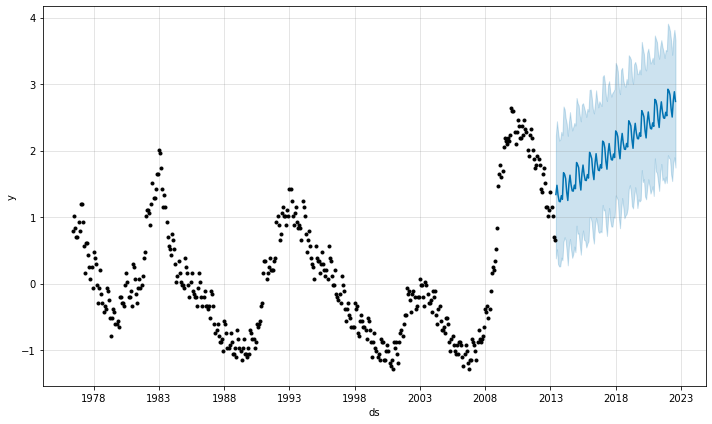

In [ ]:
fig1 = ph_model.plot(forecast)

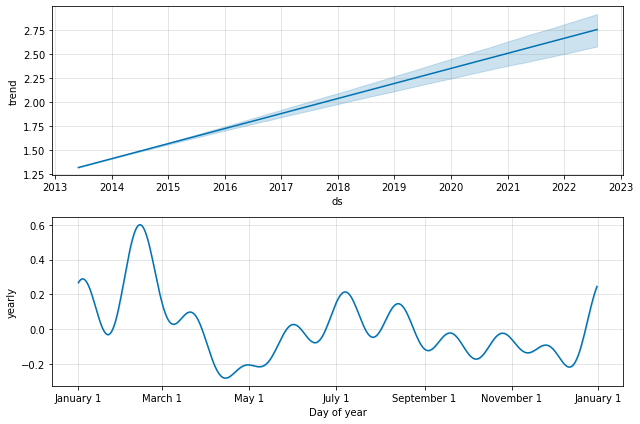

In [ ]:
fig2 = ph_model.plot_components(forecast)


## LSTM Model

In [ ]:
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
 
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # utilize the LSTM model in torch.nn
        self.linear1 = nn.Linear(hidden_size, output_size) #
 
    def forward(self, _x):
        x, _ = self.lstm(_x) # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.linear1(x)
        x = x.view(s, b, -1)
        return x



In [ ]:
def lossFunction(evaluation = 'MSE'):
    if evaluation == 'Huber':
        criterion = nn.HuberLoss()
    elif evaluation == 'SmoothL1':
        criterion = nn.SmoothL1Loss()
    else:
        criterion = nn.MSELoss()
    return criterion

#loss_function = lossFunction(evaluation = 'MSE')

In [ ]:
def train(loss_function, opt, prev_loss = PREV_LOSS, max_epochs = MAX_EPOCHS):
    
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 20, output_size=OUTPUT_FEATURES_NUM, num_layers=1).to(device)  # 20 hidden units
    
    if opt == 'Adagrad':
        optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD(lstm_model.parameters(), lr=LEARNING_RATE)
    else:
        optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
 
    prev_loss = PREV_LOSS
    max_epochs = MAX_EPOCHS    
    
    lstm_model.train()
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if loss < prev_loss:
            prev_loss = loss
 
        if loss.item() < 1e-3:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch + 1, max_epochs, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch + 1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch + 1, max_epochs, loss.item()))
    
    return lstm_model

In [ ]:
def evaluation(loss_function, lstm_model):

    pred_y_for_train = lstm_model(train_x_tensor).to(device)
    pred_y_for_train = pred_y_for_train.cpu().view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    lstm_model = lstm_model.eval()  # switch to testing model
 
    test_x_tensor = test_x.reshape(-1, 1,
                                   INPUT_FEATURES_NUM)
    test_x_tensor = torch.from_numpy(test_x_tensor)  
    test_x_tensor = test_x_tensor.to(device)
 
    pred_y_for_test = lstm_model(test_x_tensor)
    pred_y_for_test = pred_y_for_test.cpu().view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    loss = loss_function(torch.from_numpy(pred_y_for_test), torch.from_numpy(test_y))
    print("test RMSE:", np.sqrt(loss.item()))
    return pred_y_for_train, pred_y_for_test

In [ ]:
def viz(evaluation, train_y = train_y):
    pred_y_for_train, pred_y_for_test = evaluation
    plt.figure()
    plt.plot(range(len(train_y)), train_y, 'b', label='y_trn')
    plt.plot(range(len(train_y)), pred_y_for_train, 'y--', label='pre_trn')
 
    plt.plot(range(len(train_y),len(train_y)+len(test_y)), test_y, 'k', label='y_tst')
    plt.plot(range(len(train_y),len(train_y)+len(test_y)), pred_y_for_test, 'm--', label='pre_tst')
 
    plt.xlabel('t')
    plt.ylabel('Rate')
    plt.show()


## Effectiveness Comparison of Multiple Loss Functions


In [ ]:
lossFunction = lossFunction('MSE')

Epoch: [100/2000], Loss:0.03035
Epoch: [200/2000], Loss:0.02347
Epoch: [300/2000], Loss:0.01507
Epoch: [400/2000], Loss:0.00919
Epoch: [500/2000], Loss:0.00687
Epoch: [600/2000], Loss:0.00488
Epoch: [700/2000], Loss:0.00370
Epoch: [800/2000], Loss:0.00277
Epoch: [900/2000], Loss:0.00264
Epoch: [1000/2000], Loss:0.00192
Epoch: [1100/2000], Loss:0.00149
Epoch: [1200/2000], Loss:0.00137
Epoch: [1300/2000], Loss:0.00146
Epoch [1355/2000], Loss: 0.00100
The loss value is reached
test RMSE: 1.4482956900202393


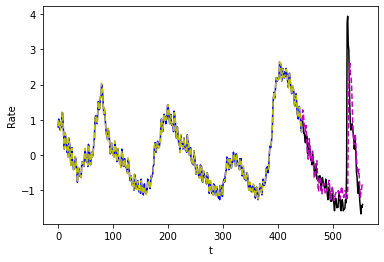

In [ ]:
t = train(lossFunction, 'Adam')
e = evaluation(lossFunction, t)
viz(e)

Epoch: [100/2000], Loss:0.13792
Epoch: [200/2000], Loss:0.08878
Epoch: [300/2000], Loss:0.08108
Epoch: [400/2000], Loss:0.07544
Epoch: [500/2000], Loss:0.07108
Epoch: [600/2000], Loss:0.06753
Epoch: [700/2000], Loss:0.06449
Epoch: [800/2000], Loss:0.06184
Epoch: [900/2000], Loss:0.05950
Epoch: [1000/2000], Loss:0.05743
Epoch: [1100/2000], Loss:0.05561
Epoch: [1200/2000], Loss:0.05402
Epoch: [1300/2000], Loss:0.05264
Epoch: [1400/2000], Loss:0.05145
Epoch: [1500/2000], Loss:0.05043
Epoch: [1600/2000], Loss:0.04955
Epoch: [1700/2000], Loss:0.04881
Epoch: [1800/2000], Loss:0.04817
Epoch: [1900/2000], Loss:0.04761
Epoch: [2000/2000], Loss:0.04711
test RMSE: 1.439996293381053


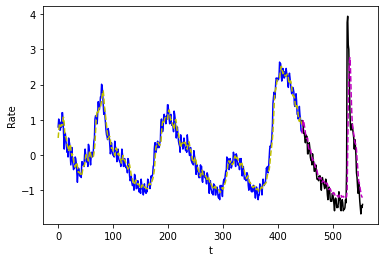

In [ ]:
t = train(lossFunction, 'SGD')
e = evaluation(lossFunction, t)
viz(e)

Epoch: [100/2000], Loss:0.03128
Epoch: [200/2000], Loss:0.02420
Epoch: [300/2000], Loss:0.02120
Epoch: [400/2000], Loss:0.01472
Epoch: [500/2000], Loss:0.00867
Epoch: [600/2000], Loss:0.00589
Epoch: [700/2000], Loss:0.00525
Epoch: [800/2000], Loss:0.00337
Epoch: [900/2000], Loss:0.00211
Epoch: [1000/2000], Loss:0.00144
Epoch: [1100/2000], Loss:0.00166
Epoch [1167/2000], Loss: 0.00100
The loss value is reached
test RMSE: 1.426367317877707


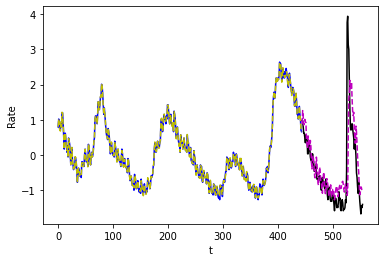

In [ ]:
t = train(lossFunction, 'Adagrad')
e = evaluation(lossFunction, t)
viz(e)